# Model Training

This notebook defines two models, a SVM and an ANN, to predict whether a user will accept an offer or not.

In [57]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

from tensorflow import keras
from tensorflow.keras import layers, activations
import tensorflow as tf

#from sagemaker.tensorflow import TensorFlow
#import sagemaker

#import warnings
#warnings.filterwarnings('ignore')


### load from local

In [40]:
filepath = '../formatted_data/combined.csv'
data = pd.read_csv(filepath)
data

,event_offer completed,event_offer received,event_offer viewed,event_transaction,difficulty,duration,mobile,social,web,offer_bogo,...,"age_(39, 49]","age_(49, 59]","age_(59, 69]","age_(69, 79]","age_(79, 89]","age_(89, 99]","age_(99, 109]","income_(30000, 60000]","income_(60000, 90000]","income_(90000, 120000]"
0,0,1,0,0,0.25,0.571429,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,0,0,1.00,1.000000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,0,0.50,0.571429,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,0,0.50,1.000000,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,0,0,0.50,0.285714,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,0,0,0,1,0.00,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306530,0,0,0,1,0.00,0.000000,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306531,0,0,0,1,0.00,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306532,0,0,0,1,0.00,0.000000,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### load from aws S3

In [42]:
#data = pd.DataFrame(data).fillna(0)
#data = data.drop(['id_offer','id_customer','offer_id','amount','reward'], axis=1)

### Train Test Split

In [43]:
data_X = data.drop('event_offer completed', axis=1)
data_y = data.loc[:, ['event_offer completed']]

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [44]:
y_train = y_train.values.ravel()
y_val   = y_val.values.ravel()
y_test  = y_test.values.ravel()

### Support Vector Machine

In [45]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [46]:
#clf.predict(X_val)
acc = clf.score(X_val, y_val)
print(f'Test accuracy: {acc}')

Test accuracy: 0.8926549986135351


### Neural Network

In [47]:
X_train_nn = X_train.values
y_train_nn = y_train

In [48]:
# define hyperparameters
epochs = 10
lr = 0.1

# define layer shape
# input shape is the number of features of X_train
# output shape is the number of featres of y_train
input_shape, hidden_shape, output_shape = len(X_train_nn[0]), len(X_train_nn[0])*1.5, len(y_train_nn[0])

In [49]:
# define tensorflow model
model = keras.models.Sequential(
    [
            keras.Input(shape=input_shape),
            layers.Dense(hidden_shape, activation='relu'),
            layers.Dense(hidden_shape, activation='relu'),
            layers.Dense(output_shape, activation="relu"),
    ]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 40)                1120      
_________________________________________________________________
dense_15 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_16 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 41        
Total params: 4,441
Trainable params: 4,441
Non-trainable params: 0
_________________________________________________________________


In [50]:
# compile model
model.compile(loss="mean_squared_error", optimizer="adam", \
              metrics=["mean_absolute_error"])
# fit model
history = model.fit(X_train, y_train, epochs=epochs, verbose=1)

Epoch 1/10
5748/5748 [==============================] - 5s 839us/step - loss: 0.1107 - mean_absolute_error: 0.1107
Epoch 2/10
5748/5748 [==============================] - 5s 880us/step - loss: 0.1105 - mean_absolute_error: 0.1105 0s - loss: 0.1105 - mean_absolute_er
Epoch 3/10
5748/5748 [==============================] - 5s 868us/step - loss: 0.1107 - mean_absolute_error: 0.1107 1s - loss
Epoch 4/10
5748/5748 [==============================] - 5s 835us/step - loss: 0.1113 - mean_absolute_error: 0.1113 0s - loss: 0.1115 - mean_absolu
Epoch 5/10
5748/5748 [==============================] - 5s 845us/step - loss: 0.1100 - mean_absolute_error: 0.1100
Epoch 6/10
5748/5748 [==============================] - 5s 838us/step - loss: 0.1093 - mean_absolute_error: 0.1093 1s - loss: 0.1091 - mean_absolute_error: 0. - ETA: 1s - loss: 0.109
Epoch 7/10
5748/5748 [==============================] - 5s 890us/step - loss: 0.1114 - mean_absolute_error: 0.1114 0s - loss: 0.1114 - mean_absolute_error: 
Epoch 

Accuracy of predictions: 88.98%


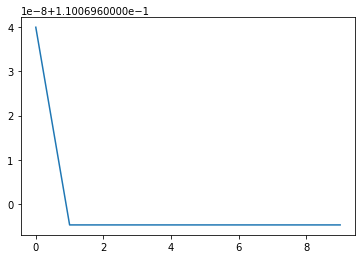

In [52]:
# predict on test data
predictions = model.predict(X_test)
#print(predictions)

# calculate accuracy
acc = accuracy_score(np.round(predictions), y_test)
print(f'Accuracy of predictions: {round(acc,4)*100}%')

# show loss of training over epochs
loss_list = history.history['loss']
x = list(np.arange(epochs))
plt.plot(x, loss_list)
plt.show()

In [55]:
tf_version = tf.__version__
tf_version

#Sagemaker role, make sure you've allowed access to any S3 bucket
role = sagemaker.get_execution_role()
role

NameError: name 'sagemaker' is not defined

In [ ]:
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(entry_point='train.py', 
                          role=role,
                          instance_count=1, 
                          instance_type='ml.p2.xlarge',
                          framework_version=tf_version, 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={
                              'epochs': 30
                          }
                         )

In [ ]:
tf_estimator.fit({'train': training_input_path})

In [ ]:
predictor = estimator.deploy(initial_instance_count = 1, instance_type = 'ml.p2.xlarge')

In [ ]:
predictions = predictor.predict(X_test)

In [ ]:
acc = accuracy_score(np.round(predictions), y_test)
print(f'Accuracy of predictions: {round(acc,4)*100}%')

## Comparison of models & Results